# A/B-тестирование для интернет-магазина

Интернет-магазин хочет выбрать наилучшую гипотезу для увеличения выручки, протестировать ее с помощью A/B-теста и принять или отложить решение об изменении.

## Содержание:

1. [Приоритизация гипотез.](#1)
2. [Анализ A/B-теста](#2)

  2.1 [Предобработка данных](#2.1)

  2.2 [Анализ кумулятивных значений выручки, среднего чека и конверсии по группам.](#2.2)

  2.3 [Проверка гипотез о статистической значимости различий в конверсии и среднем чеке между группами А и В по сырым данным](#2.3)
  
  2.4 [Избавление от выбросов](#2.4)
  
  2.5 [Проверка гипотез о статистической значимости различий в конверсии и среднем чеке между группами А и В по очищенным данным](#2.5)
  
3. [Выводы](#2.6)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
def checking(df):
    print(df.head())
    print()
    print(df.info())
    print()
    print('duplicated:', df.duplicated().sum())
    print()
    print(df.hist(bins=20))

## Приоритизация гипотез.<a name="1"></a>

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Приоритизация методами ICE и RICE

In [4]:
hypothesis['Priority_ICE'] = (hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']).round(1)
hypothesis = hypothesis.sort_values(by='Priority_ICE', ascending=False)
hypothesis['Priority_ICE_rating'] = np.arange(1, len(hypothesis)+1)

hypothesis['Priority_RICE'] = hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']
hypothesis = hypothesis.sort_values(by='Priority_RICE', ascending=False)
hypothesis['Priority_RICE_rating'] = np.arange(1, len(hypothesis)+1)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,Priority_ICE,Priority_ICE_rating,Priority_RICE,Priority_RICE_rating
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2,3,112.0,1
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0,5,56.0,2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3,2,40.0,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0,4,40.0,4
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2,1,16.2,5
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1,8,9.0,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0,6,4.0,7
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3,7,4.0,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0,9,3.0,9


**Вывод:** Приоритет гипотез меняется в зависимости от применяемого подхода. RICE учитывается не только предполагаемое влияние и усилия по реализации доработки, но и количество пользователей, которых изменение коснется. Интернет-магазин - массовый сервис, поэтому последним параметром пренебрегать не стоит, протестируем в первую очередь гипотезу о добавлении формы подписки на все страницы, она лидирует по методу RICE, но и в модели ICE занимает призовое 3 место.

## Анализ A/B-теста<a name="2"></a>

### Предобработка данных<a name="2.1"></a>

    Проведем общую проверку данных на корректность формата, наличие дубликатов и распределения.
    И выполним специфическую проверку на нормальность распределения, объем групп и соблюдается ли условие, что 1 пользователь видит только 1 версию (т.е. входит в одну группу).

   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     1650     B
1     2804400009  3642806036  2019-08-15      730     B
2     2961555356  4069496402  2019-08-15      400     A
3     3797467345  1196621759  2019-08-15     9759     B
4     2282983706  2322279887  2019-08-15     2308     B

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

duplicated: 0

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d28153e90>


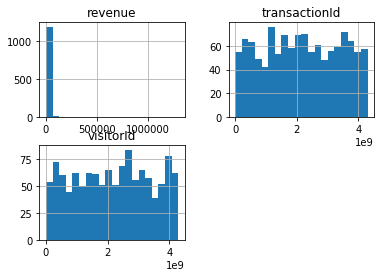

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
checking(orders)

         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

duplicated: 0

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d25810d50>]]


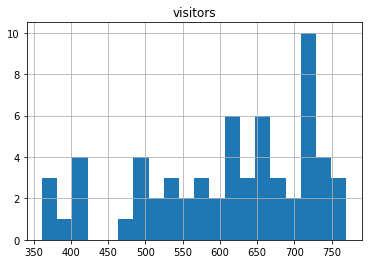

In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
checking(visitors)

In [7]:
#Тест Шапиро-Уилка на нормальность распределения
for group in ('A', 'B'):
    if st.shapiro(orders.query('group==group')['revenue'])[1] < 0.05:
        print('Выручка в группе {} не распределена нормально'.format(group))
    else:
        print('Выручка в группе {} распределена нормально'.format(group))

Выручка в группе A не распределена нормально
Выручка в группе B не распределена нормально


In [8]:
users_group = orders[['visitorId', 'group']].drop_duplicates()
users_ok = users_group.groupby('visitorId').count()[users_group.groupby('visitorId').count()['group'] == 1].index
print('Пользователей, входящих в обе группы сразу:', orders.visitorId.nunique() - len(users_ok))

Пользователей, входящих в обе группы сразу: 58


Реализация нашего теста где-то дала сбой. Вероятно, была пропущена стадия А/А-теста, на которой в числе прочего проверяется безошибочность работы алгоритма, следящего, чтобы одному и тому пользователю на всем протяжении теста показывалась только 1 версия страницы. Данные о заказах этих посетителей не могут быть однозначно отнесены к той или другой версии страницы, поэтому далее будем работать только с корректно распределенными пользователями.

In [9]:
orders = orders.query('visitorId.isin(@users_ok)')

In [10]:
orders.groupby('group')['visitorId'].nunique()

group
A    445
B    528
Name: visitorId, dtype: int64

##### Выводы: 
Данные представлены в корректном формате. Некоторые пользователи попали одновременно в группы А и В, и, т.к. это нарушает методику проведения А/В-теста, мы их убрали из рассмотрения. Сами группы оказались сопоставимых размеров. С первого взгляда заметно, что у значений выручки есть выбросы, и само распределение не нормальное, поэтому для оценки различий между группами будем применять непараметрический тест Уилкоксона-Манна-Уитни.

### Анализ кумулятивных значений выручки, среднего чека и конверсии по группам.<a name="2.2"></a>

In [11]:
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[(orders['date'] <= x['date'])&(orders['group'] == x['group'])]
                                     .agg({'date' : 'max', 
                                           'group' : 'max', 
                                           'transactionId' : 'nunique', 
                                           'visitorId' : 'nunique', 
                                           'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[(visitors['date'] <= x['date'])&(visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 
                                             'group' : 'max', 
                                             'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

#Для дальнейшего исследования потребуется конверсия, посчитаем ее уже сейчас.
cumulativeData['conversion'] = cumulativeData['transactionId']/cumulativeData['visitors']

#Для удобства дальнейшего исследования разнесем данные групп в отдельные столбцы
cumulativeData = cumulativeData.query('group == "A"').merge(cumulativeData.query('group == "B"'), on=['date'], suffixes=('A', 'B'))
cumulativeData = cumulativeData.rename(columns={'transactionIdA':'ordersA',
                                                             'visitorIdA':'buyers',
                                                              'transactionIdB':'ordersB',
                                                             'visitorIdB':'buyersB',
                                                             }, errors="raise")
cumulativeData.head()

,date,groupA,ordersA,buyers,revenueA,visitorsA,conversionA,groupB,ordersB,buyersB,revenueB,visitorsB,conversionB
0,2019-08-01,A,23,19,142779,719,0.031989,B,17,17,59758,713,0.023843
1,2019-08-02,A,42,36,234381,1338,0.031390,B,40,39,221801,1294,0.030912
2,2019-08-03,A,66,60,346854,1845,0.035772,B,54,53,288850,1803,0.029950
3,2019-08-04,A,77,71,388030,2562,0.030055,B,68,66,385740,2573,0.026428
4,2019-08-05,A,99,92,474413,3318,0.029837,B,89,87,475648,3280,0.027134


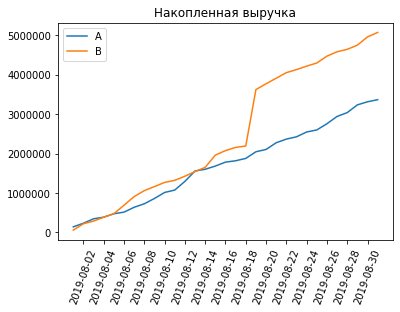

In [12]:
plt.plot(cumulativeData['date'], cumulativeData['revenueA'], label='A')
plt.plot(cumulativeData['date'], cumulativeData['revenueB'], label='B')
plt.title('Накопленная выручка')
plt.legend() 
plt.xticks(np.arange(pd.to_datetime(cumulativeData['date']).min().day, 
                     pd.to_datetime(cumulativeData['date']).max().day,
                    2), rotation=70)
plt.show()

Накопленная выручка группы В выглядит немного больше до момента, когда некий выброс (заказ на аномально большую сумму) сдвинул его вверх. Сложно сказать, как повел бы себя график без этого случайно попавшего сюда заказа.

**Посмотрим на графики. Кумулятивный средний чек по группам**

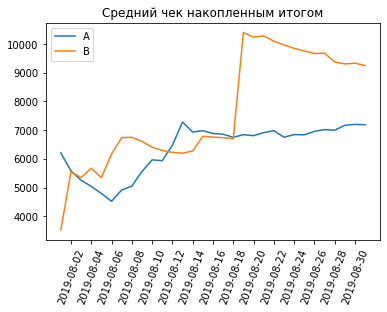

In [13]:
plt.plot(cumulativeData['date'], cumulativeData['revenueA']/cumulativeData['ordersA'], label='A')
plt.plot(cumulativeData['date'], cumulativeData['revenueB']/cumulativeData['ordersB'], label='B')
plt.legend()
plt.title('Средний чек накопленным итогом')
plt.xticks(np.arange(pd.to_datetime(cumulativeData['date']).min().day, 
                     pd.to_datetime(cumulativeData['date']).max().day,
                    2), rotation=70)
plt.show()

Поведение среднего чека до вмешательства аномалий очень неоднозначно.

**График относительного изменения кумулятивного среднего чека группы B к группе A**

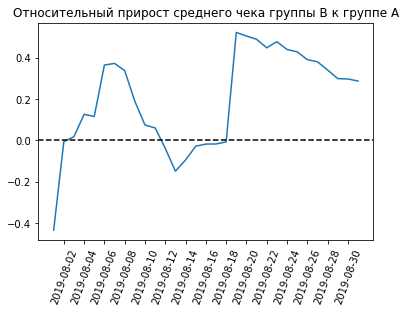

In [14]:
plt.plot(cumulativeData['date'], (cumulativeData['revenueB']/cumulativeData['ordersB'])/
                                        (cumulativeData['revenueA']/cumulativeData['ordersA']) - 1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительный прирост среднего чека группы В к группе А')
plt.xticks(np.arange(pd.to_datetime(cumulativeData['date']).min().day, 
                     pd.to_datetime(cumulativeData['date']).max().day,
                    2), rotation=70)
plt.show()

Ожидаемая картина и на графике относительных значений одной группы к другой - определенные выводы сделать невозможно.

**График кумулятивной конверсии по группам**

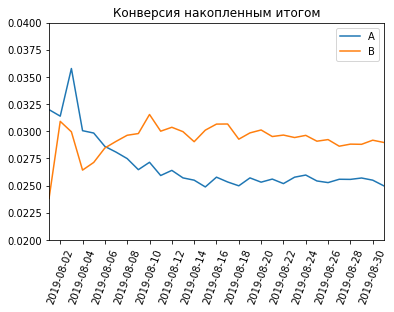

In [15]:
plt.plot(cumulativeData['date'], cumulativeData['conversionA'], label='A')
plt.plot(cumulativeData['date'], cumulativeData['conversionB'], label='B')
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.04]) 
plt.title('Конверсия накопленным итогом')
plt.xticks(np.arange(pd.to_datetime(cumulativeData['date']).min().day, 
                     pd.to_datetime(cumulativeData['date']).max().day,
                    2), rotation=70)
plt.show()

Что касается конверсии, группа В выглядит стабильно лучше А. Эту разницу в конверсии интересно будет проверить статистическими методами.

**График относительного изменения кумулятивной конверсии группы B к группе A**

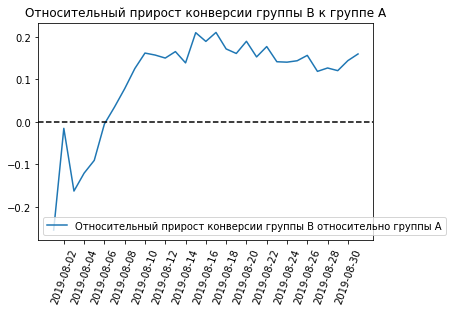

In [16]:
plt.plot(cumulativeData['date'], cumulativeData['conversionB']/cumulativeData['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительный прирост конверсии группы В к группе А')
plt.xticks(np.arange(pd.to_datetime(cumulativeData['date']).min().day, 
                     pd.to_datetime(cumulativeData['date']).max().day,
                    2), rotation=70)
plt.show()

Начальные колебания графика ни о чем не говорят, а со временем конверсия группы B стала держаться уверенно выше конверсии группы А.

## Проверка гипотез о статистической значимости различий в конверсии и среднем чеке между группами А и В по сырым данным.<a name="2.3"></a>

**Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным.**

Подготовим выборки для теста Уилкоксона-Манна-Уитни. Для этого создадим списки количества покупок для каждого посетителя, включая тех, кто ничего не купил, для них значением будет 0.

In [17]:
ordersByUsers = orders.groupby(['visitorId', 'group'], as_index=False).agg({'transactionId' : 'nunique', 'revenue':'sum'})
ordersByUsers.columns = ['visitorId', 'group', 'transactions', 'revenue']

In [18]:
sampleA = pd.concat([ordersByUsers.query('group == "A"')['transactions'], 
           pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - 
                                          len(ordersByUsers.query('group == "A"'))))])
sampleB = pd.concat([ordersByUsers.query('group == "B"')['transactions'], 
           pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - 
                                          len(ordersByUsers.query('group == "B"'))))])

**Гипотеза**

Н0 - Конверсия в группах А и В одинаковая.

Н1 - Конверсии группы А и В различаются.

In [19]:
print('Конверсия группы А: ', sampleA.mean().round(4), '\n', 'Кoнверсия группы В: ', sampleB.mean().round(4), sep='')

Конверсия группы А: 0.025
Кoнверсия группы В: 0.029


In [20]:
print('p-value =', st.mannwhitneyu(sampleA, sampleB)[1])

p-value = 0.0055090420550073455


In [21]:
print('Прирост конверсии в группе В к А: {:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))

Прирост конверсии в группе В к А: 15.98%


p-value достаточно мало, чтобы отвергнуть нулевую гипотезу и признать, что различие между группами в конверсии есть. B показывает себя успешнее А почти на 16%.

**Гипотеза**

Н0 - Средний чек в группах А и В одинаковый.

Н1 - Средний чек в группах А и В различается.

In [22]:
print('Средний чек группы А: ', orders.query('group == "A"')['revenue'].mean().round(4), '\n',
      'Средний чек группы В: ', orders.query('group == "B"')['revenue'].mean().round(4), sep='')

Средний чек группы А: 7189.4359
Средний чек группы В: 9249.9489


In [23]:
print('p-value =', st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1])

p-value = 0.41474544990747664


Несмотря на кажущуюся разницу, статистически значимых различий в среднем чеке между группами нет.

## Избавление от выбросов<a name="2.4"></a>

Графики в проведенном исследовании указывают на наличие аномальных значений, искажающих итоговые результаты тестирования. К таким значениям относятся редкие покупки на нетипично большие суммы и нетипично большое количество заказов от одного покупателя. Найдем эти выбросы и проверим значимость различий в конверсии и среднем чеке без них.

**Построим точечный график количества заказов по пользователям и оценим значения 95-го и 99-го перцентиля, чтобы определить границу выбросов по этому параметру**

Перцентили 95 и 99: [1. 2.]


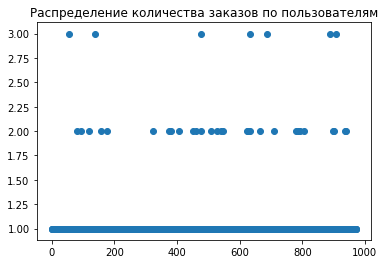

In [24]:
print('Перцентили 95 и 99:', np.percentile(ordersByUsers['transactions'], [95, 99]))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['transactions']) 
plt.title('Распределение количества заказов по пользователям')
plt.show()

Почти все пользователи совершили 1 заказ, не более 5% - 2 и 3.

**Оценим тем же способом точечный график стоимостей заказов**

Перцентили 95 и 99 [28910. 59082.]


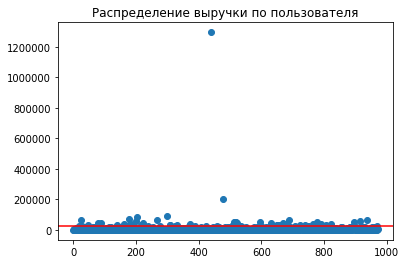

In [25]:
print('Перцентили 95 и 99', np.percentile(ordersByUsers['revenue'], [95, 99]))
plt.scatter(np.arange(0, len(ordersByUsers)), ordersByUsers['revenue'])
plt.axhline(y=np.percentile(ordersByUsers['revenue'], 95), color='r')
plt.title('Распределение выручки по пользователя')
plt.show()

Вот и милионный заказ, обеспечивавший "победу" группы B. Он такой один на всю выборку, и мог попасть в любую группу. Для того, чтобы оценить группы более надежно, его и несколько других нетипично дорогих заказов стоит исключить.

Пользователей, совершивших более 1 заказа или заказов на 29+ тыс. уберем из рассмотрения, чтобы оценить, как ведет себя конверсия и средний чек у массового покупателя. По каждому критерию теряем не более 5% всех пользователей.

In [26]:
users_with_many_orders = orders.groupby('visitorId')['transactionId'].nunique()\
                        [orders.groupby('visitorId')['transactionId'].nunique() > 1].index

users_with_much_revenue = orders.groupby('visitorId')['revenue'].sum()\
                          [orders.groupby('visitorId')['revenue'].sum() > 29000].index

abnormal_users = pd.concat([pd.Series(users_with_many_orders), pd.Series(users_with_much_revenue)]).drop_duplicates()

## Проверка гипотез о статистической значимости различий в конверсии и среднем чеке между группами А и В по очищенным данным.<a name="2.5"></a>

**Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «очищенным» данным.**

In [27]:
sampleAfiltered = pd.concat([ordersByUsers.query('group == "A" and visitorId not in @abnormal_users')['transactions'], 
           pd.Series(0, index = np.arange(visitors.query('group == "A"')['visitors'].sum() - 
                                          len(ordersByUsers.query('group == "A"'))))])

sampleBfiltered = pd.concat([ordersByUsers.query('group == "B" and visitorId not in @abnormal_users')['transactions'], 
           pd.Series(0, index = np.arange(visitors.query('group == "B"')['visitors'].sum() - 
                                          len(ordersByUsers.query('group == "B"'))))])

**Гипотеза**

Н0 - Конверсия в очищенных группах А и В одинаковая.

Н1 - Конверсии в очищенных группах А и В различаются.

In [28]:
print('Конверсия группы А: ', sampleAfiltered.mean().round(4), '\n', 'Кoнверсия группы В: ', sampleBfiltered.mean().round(4), sep='')

Конверсия группы А: 0.0218
Кoнверсия группы В: 0.0257


In [29]:
print('p-value =', st.mannwhitneyu(sampleAfiltered, sampleBfiltered)[1])

p-value = 0.006220991480621281


In [30]:
print('Прирост конверсии в группе В к А: {:.2%}'.format(sampleBfiltered.mean() / sampleAfiltered.mean() - 1))

Прирост конверсии в группе В к А: 18.01%


Конверсия обеих групп стала немного ниже, но относительное различие только увеличилось: теперь группа В опережает А на 18%.

**Гипотеза**

Н0 - Средний чек в очищенных группах А и В одинаковый.

Н1 - Средний чек в очищенных группах А и В различается.

In [31]:
print('Средний чек группы А: ', orders.query('group == "A" and visitorId not in @abnormal_users')['revenue'].mean().round(4), '\n',
      'Средний чек группы В: ', orders.query('group == "B" and visitorId not in @abnormal_users')['revenue'].mean().round(4), sep='')

Средний чек группы А: 5160.3554
Средний чек группы В: 5114.5103


In [32]:
print('p-value =', st.mannwhitneyu(orders.query('group == "A" and visitorId not in @abnormal_users')['revenue'], 
                                   orders.query('group == "B" and visitorId not in @abnormal_users')['revenue'])[1])

p-value = 0.4181613749626989


In [33]:
print('Прирост среднего чека в группе В к А: {:.2%}'.format(orders.query('group == "B" and visitorId not in @abnormal_users')['revenue'].mean()
                                                            / orders.query('group == "A" and visitorId not in @abnormal_users')['revenue'].mean() - 1))

Прирост среднего чека в группе В к А: -0.89%


Аномальные суммы покупок вносили большой перекос в данные. После их удаления средние чеки в группах стали практически равны.

## Выводы

Для увеличения выручки интернет-магазина было предложено 9 гипотез. Используя методы приоритизации ICE и RICE мы выбрали наиболее персипективную: добавить форму подписки на все основные страницы.

Тестирование проводилось в течение августа 2019 г. Пользователи сайта были разделены на 2 почти одинаковые по объему группы, контрольной (группе А) показывался старый дизайн, экспериментальный (группе В) - обновленный дизайн с добавленными формами. В ходе реализации теста были допущены ошибки, в результате которых некоторые покупатели видели и одну, и другую версию сайта, их мы убрали из рассмотрения, чтобы, несмотря на допущенные нарушение методологии, получить максимально верные выводы. Для дальнейшего развития направления А/В-тестирования в компании рекомендуется доработать процесс и предварительно проводить А/А-тест, который покажет слабые места системы. 

Для текущего эксперимента наиболее важными параметрами были выбраны конверсия и средний чек.

Статистический критерий Уилкоксона-Манна-Уитни показал, что конверсия в группе В выше по сравнению с группой А на 16% на "сырых" данных и на 18% на очищенных данных (из которых удалены параметры аномально больших заказов - более 29 тыс.р. и большое колечество заказов, принадлежащих одному пользователю - более 3).

Тот же критерий показал, что различия в среднем чеке нет ни до удаления выбросов, ни после. Более того, средний чек по группам практически сравнялся после удаления аномально больших заказов.

Задачей тестирования ставился поиск возможности для увеличения выручки. Значимый прирост конверсии в экспериментальной группе при сохранении среднего чека на том же уровне, что и в контрольной, позволяет признать группу В победителем, тест остановить, а добавленные формы подписки на всех страницах показывать всем пользователям. 